1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [94]:
import pandas as pd
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df = df.drop(['Unnamed: 0'],1)

df.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [95]:
df["default"] = df["default"].astype('category')
df["student"] = df["student"].astype('category')
print(df["default"])
df["default"]= df["default"].cat.rename_categories([0,1])
df["student"] = df["student"].cat.rename_categories([0,1])
print(df["default"])

#df_default=pd.get_dummies(df['default'])
#df_student=pd.get_dummies(df['student'])
    
#df_final = pd.concat([df_default,df_student,df[['balance','income']]],axis=1)

df.head(5)
#df_final.head(5)

0        No
1        No
2        No
3        No
4        No
5        No
6        No
7        No
8        No
9        No
10       No
11       No
12       No
13       No
14       No
15       No
16       No
17       No
18       No
19       No
20       No
21       No
22       No
23       No
24       No
25       No
26       No
27       No
28       No
29       No
       ... 
9970     No
9971     No
9972     No
9973     No
9974     No
9975     No
9976     No
9977     No
9978    Yes
9979     No
9980     No
9981     No
9982     No
9983     No
9984     No
9985     No
9986     No
9987     No
9988     No
9989     No
9990     No
9991     No
9992     No
9993     No
9994     No
9995     No
9996     No
9997     No
9998     No
9999     No
Name: default, dtype: category
Categories (2, object): [No, Yes]
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20 

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

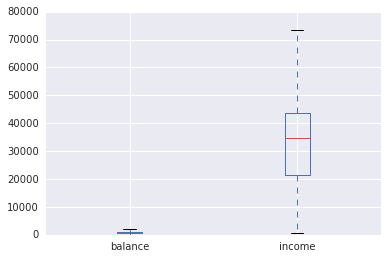

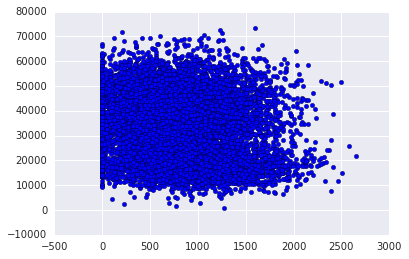

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df.boxplot(return_type='axes')
plt.show()

plt.scatter(df.balance, df.income)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [97]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
#from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

Area under the ROC curve : 0.932928064843


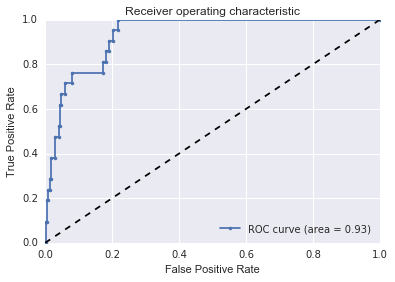

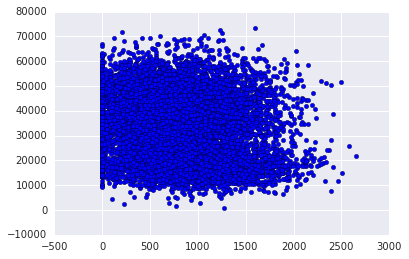

/Users/verayujiefeng/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Unknown label type: 0       44361.625074
1       12106.134700
2       31767.138947
3       35704.493935
4       38463.495879
5        7491.558572
6       24905.226578
7       17600.451344
8       37468.529288
9       29275.268293
10      21871.073089
11      13268.562221
12      28251.695345
13      44994.555849
14      23810.174050
15      45042.413036
16      50265.312354
17      17636.539617
18      61566.106118
19      26464.631389
20      50500.182198
21      32457.509075
22      51317.883082
23      30466.103257
24      34353.314305
25      25211.332161
26      41473.511801
27      32189.094952
28      39376.394619
29      16556.070205
            ...     
9970    25687.326050
9971    20975.560495
9972    14455.865365
9973    37668.366788
9974    26051.398320
9975    21287.942487
9976    25401.133121
9977    16624.339111
9978    47287.257108
9979    30697.245062
9980    13684.789952
9981    40656.951448
9982    59441.309981
9983    49861.003411
9984    52861.744197
9985    39957.127855
9986    15332.017833
9987    45479.466985
9988    41740.686597
9989    20013.350644
9990    25374.899085
9991    54802.078221
9992    45490.682463
9993    56633.448744
9994    14955.941689
9995    52992.378914
9996    19660.721768
9997    58636.156984
9998    36669.112365
9999    16862.952321
Name: income, dtype: float64

In [110]:
#df = df[df['student'] != 0]
df_1 = df[df.student != 0]
df.head(5)

y = df_1['default']
X = df_1.drop(['default'],1)

# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve :", roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

plt.scatter(df.balance, df.income)
plt.show()



C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel = 'linear',  gamma=0.7, C=C )
clf.fit(df.balance, df.income)

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.plot(xx, yy, 'k-')


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.962237942491


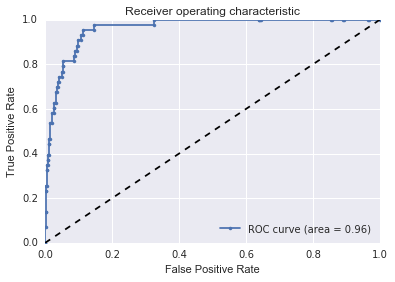

In [104]:
#df = df[df['student'] != 0]
#df = df[df.student != 0]
#df.head(5)

y = df['default']
X = df.drop(['default'],1)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve :", roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)




6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [105]:
# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

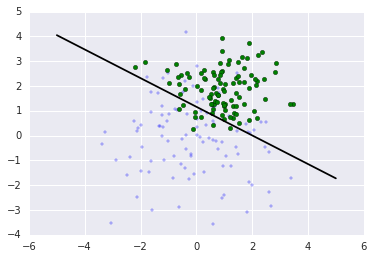

8) Find the optimal decision tree depth and compute the AUC ROC. 